<a href="https://colab.research.google.com/github/Klavierkonzert/CV/blob/Tanks-detection/WOT_detecting_tanks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Contents
## Plan:
### 1. Pretrain YOLO v8 on tanks photos (fine tuning, backbone is not trained)
### 2. Train last ~ 5 layers on screenshots from WoT game


In [1]:
import torch
import os
import glob
import shutil
from datetime import date
import matplotlib.pyplot as plt
import pandas as pd
import regex as re

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
if torch.cuda.is_available():
    print("GPU is available!")
else:
    print("GPU is not available. Please change the runtime type to GPU.")

GPU is available!


Training data

In [3]:
# Define the path to the zip file in Google Drive
zip_file_path = '/content/drive/My Drive/ML/source data/tanks/photos/tank-detect.v3i.yolov8.zip'
extract_dir = '/content/photos'
os.makedirs(extract_dir, exist_ok=True)

!unzip -q "{zip_file_path}" -d "{extract_dir}"

print(f"Files extracted to: {extract_dir}")

SCREENSHOTS_PATH = "/content/drive/My Drive/ML/source data/tanks/WOT screenshots"
PROJECT_PATH = "/content/drive/My Drive/ML/source data/tanks"

Files extracted to: /content/photos


Converting labels to YOLO format if necessary

In [4]:
def pascal_voc_to_yolo(x1, y1, x2, y2, image_w, image_h):
    return [((x2 + x1)/(2*image_w)), ((y2 + y1)/(2*image_h)), (x2 - x1)/image_w, (y2 - y1)/image_h]

In [5]:
#CONFLICTS with Torch
# !pip install pylabel
# from pylabel import importer

# dataset = importer.ImportVOC(path=SCREENSHOTS_PATH+'/annotations', path_to_images=SCREENSHOTS_PATH+'/images', name="WOT_screenshots")
# #splitting:
# dataset.splitter.StratifiedGroupShuffleSplit(train_pct=.6, val_pct=.2, test_pct=.2, batch_size=1)
# dataset.analyze.ShowClassSplits()
# #export
# dataset.export.ExportToYoloV5(output_path=SCREENSHOTS_PATH+'/training_model/labels/',yaml_file='dataset.yaml', copy_images=True, use_splits=True)

In [6]:
# dataset.analyze.class_ids

### Training a model on images of real tanks
Optional, if there is no pretrained model saved


In [7]:
trained_model_path = ''

# Check if model file has already been created
if trained_model_path:=glob.glob(os.path.join(PROJECT_PATH, 'best_*.pt'))[-1]:
    print(f"Found trained model file: {trained_model_path}. \n New model will not be trained")
else:
    print("No trained model file found in the project path.")

Found trained model file: /content/drive/My Drive/ML/source data/tanks/best_2025-10-04.pt. 
 New model will not be trained


YOLO detection model

In [8]:
!pip install ultralytics --quiet

from ultralytics import YOLO
if not trained_model_path:
  # Load a pretrained YOLOv8 model
  model = YOLO('yolov8n.pt')

  # Train the model on your dataset with backbone frozen
  # The data.yaml file in the extracted folder should contain the paths to your training and validation data.
  model.train(data='/content/photos/data.yaml', epochs=100, freeze=10) # You can adjust the number of epochs and layers to freeze
  #saving the best model
  trained_model_path = PROJECT_PATH+'/best_'+str(date.today())+'.pt'
  shutil.copy2('/content/runs/detect/train/weights/best.pt', trained_model_path)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 65.8 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


Metric on model trained on photos of real tanks

In [9]:
# Load the best trained model
#best_model_path = '/content/runs/detect/train/weights/best.pt'
best_model = YOLO(trained_model_path)

In [10]:
# Evaluate the model on the validation set
metrics = best_model.val()

# Print the metrics
print("Validation Metrics:")
print(f"  mAP50: {metrics.box.map50}")
print(f"  mAP50-95: {metrics.box.map}")
print(f"  Precision: {metrics.box.mp}")
print(f"  Recall: {metrics.box.mr}")

Ultralytics 8.3.239 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1195.8±562.5 MB/s, size: 60.4 KB)
val: Scanning /content/photos/valid/labels... 166 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 166/166 1.3Kit/s 0.1s
val: New cache created: /content/photos/valid/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 11/11 2.0it/s 5.6s
                   all        166        189      0.992      0.937      0.968      0.794
Speed: 6.0ms preprocess, 5.9ms inference, 0.0ms loss, 2.7ms postprocess per image
Results saved to /content/runs/detect/val
Validation Metrics:
  mAP50: 0.9677615868696309
  mAP50-95: 0.7938356533668072
  Precision: 0.9922150201727383
  Recall: 0.9365079365079365


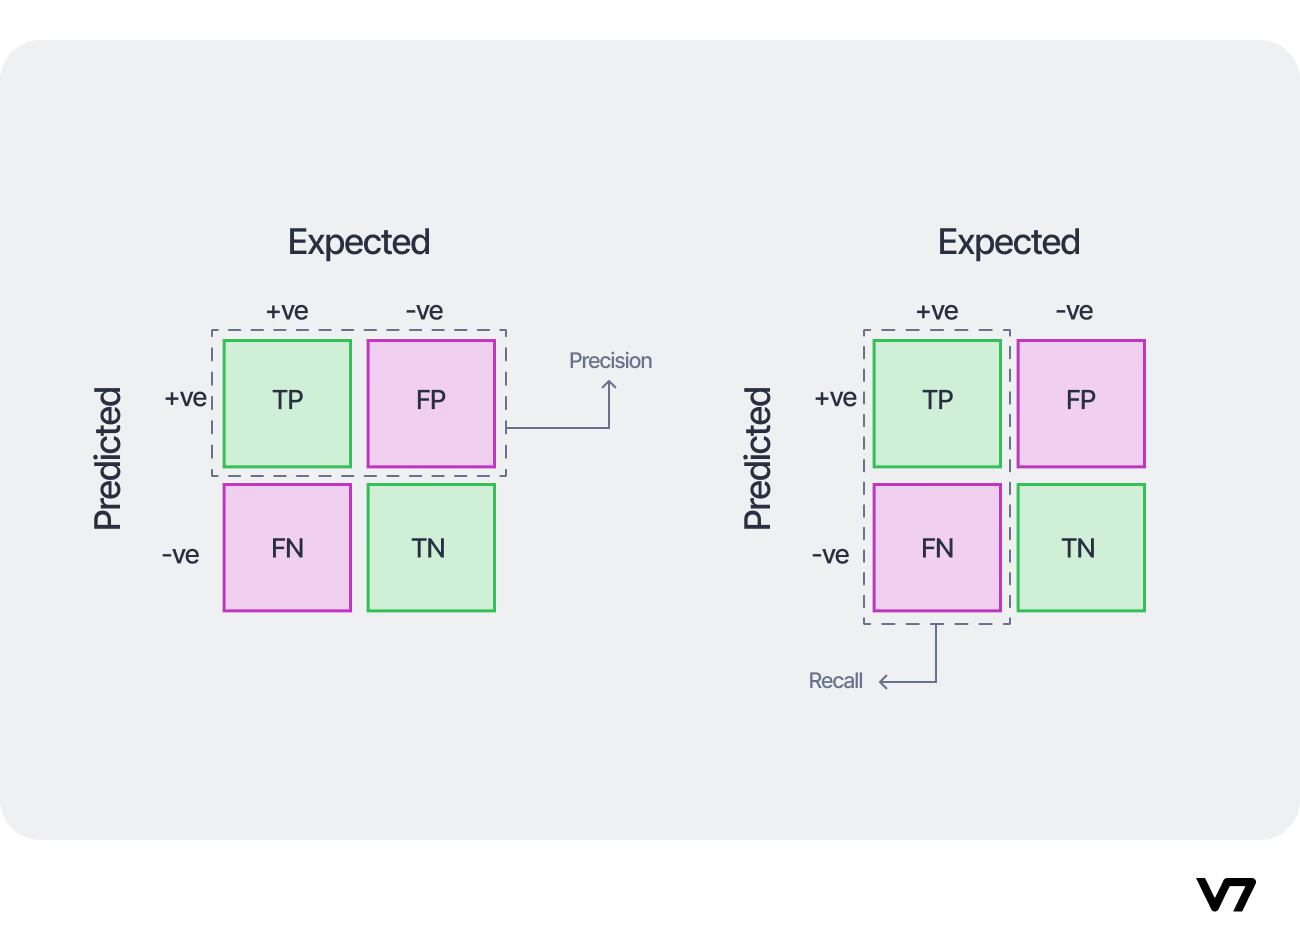

### Fine-tuning on manually annotated screenshots from WOT game

In [11]:
def fine_tuning(trained_model_path: str, n_freeze_layers: list[int]|int=10,
                epochs = 100, best_selection_metric:str='precision', restore_old_models: bool=True):
  """
  :params:
    :param trained_model_path: path to the model file, which were posttrained on real tank images
    :restore_old_models: if models were trained before, then models are searched at the folder of trained_model_path (Google Drive path)

    :returns:
      model with the best results"""
  metrics = {}
  best_model, best_selection_metric_res = None, None
  if type(n_freeze_layers) == int:
    n_freeze_layers = [n_freeze_layers]
  for n_freeze in n_freeze_layers:
    # Load the best trained model
    save_path = trained_model_path[:trained_model_path.rfind('/')]+'/models_trained_on_screenshots/'+'model_'+str(n_freeze)+'.pt'
    if restore_old_models and os.path.isfile(save_path):
      #if model has alreade been trained
      print(f"Found trained model file: {save_path}. \n New model will not be trained")
      model = YOLO(save_path)
    else:
      # train new model otherwise and save
      model = YOLO(trained_model_path)
      results = model.train(data=SCREENSHOTS_PATH+'/training_model/dataset.yaml', epochs=epochs, freeze=n_freeze) # You can adjust the number of epochs and layers to freeze
      #saving : model is selected from the last '/content/runs/detect/trainXY...' folder:
      shutil.copyfile(str(max([os.path.join('/content/runs/detect/', d)
                                for d in os.listdir('/content/runs/detect/')
                                if os.path.isdir(os.path.join('/content/runs/detect/', d)) and re.search(r'train\d*$', d)
                              ], key=lambda d: int(res if (res:=re.search(r'(\d*)$', d).group(1)) else -1))
                          )+
                                                    '/weights/best.pt',
                        save_path)

    metrics[n_freeze] = {}
    metrics[n_freeze]['map50'], metrics[n_freeze]['map'], metrics[n_freeze]['precision'], metrics[n_freeze]['recall'] = model.val().box.map50, model.val().box.map, model.val().box.mp, model.val().box.mr
    #metrics[n_freeze]['loss'] = results.

    if best_model is None or metrics[n_freeze][best_selection_metric] > best_selection_metric_res:
      best_model, best_selection_metric_res = model, metrics[n_freeze][best_selection_metric]

  df_metrics = pd.DataFrame(metrics)#, columns=['n_freeze', 'map50', 'map', 'precision', 'recall'])
  df_metrics.plot(kind='bar', legend=True)

  return best_model

Found trained model file: /content/drive/My Drive/ML/source data/tanks/models_trained_on_screenshots/model_10.pt. 
 New model will not be trained
Ultralytics 8.3.239 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.9±0.6 ms, read: 122.2±183.8 MB/s, size: 2775.6 KB)
val: Scanning /content/drive/My Drive/ML/source data/tanks/WOT screenshots/training_model/labels/val.cache... 107 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 107/107 132.7Kit/s 0.0s
val: /content/drive/My Drive/ML/source data/tanks/WOT screenshots/training_model/images/val/Screenshot_20251004_153601_WoT Blitz.jpg: corrupt JPEG restored and saved
val: /content/drive/My Drive/ML/source data/tanks/WOT screenshots/training_model/images/val/Screenshot_20251004_153631_WoT Blitz.jpg: corrupt JPEG restored and saved
val: /content/drive/My Drive/ML/source data/tanks/WOT screenshots/training_model/ima

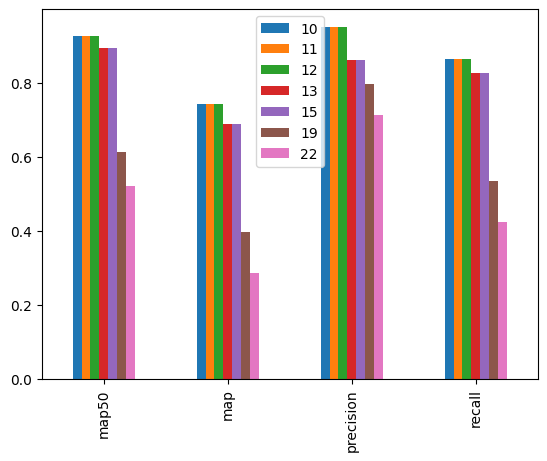

In [12]:
best_model = fine_tuning(trained_model_path, n_freeze_layers=[10, 11, 12,13, 15, 19, 22], epochs=100)#, restore_old_models=False)

### testing on a random image

Using random test image: /content/drive/My Drive/ML/source data/tanks/WOT screenshots/training_model/images/test/Screenshot_20251004_195126_WoT Blitz.jpg

image 1/1 /content/drive/My Drive/ML/source data/tanks/WOT screenshots/training_model/images/test/Screenshot_20251004_195126_WoT Blitz.jpg: 320x640 2 tanks, 39.6ms
Speed: 2.1ms preprocess, 39.6ms inference, 1.7ms postprocess per image at shape (1, 3, 320, 640)


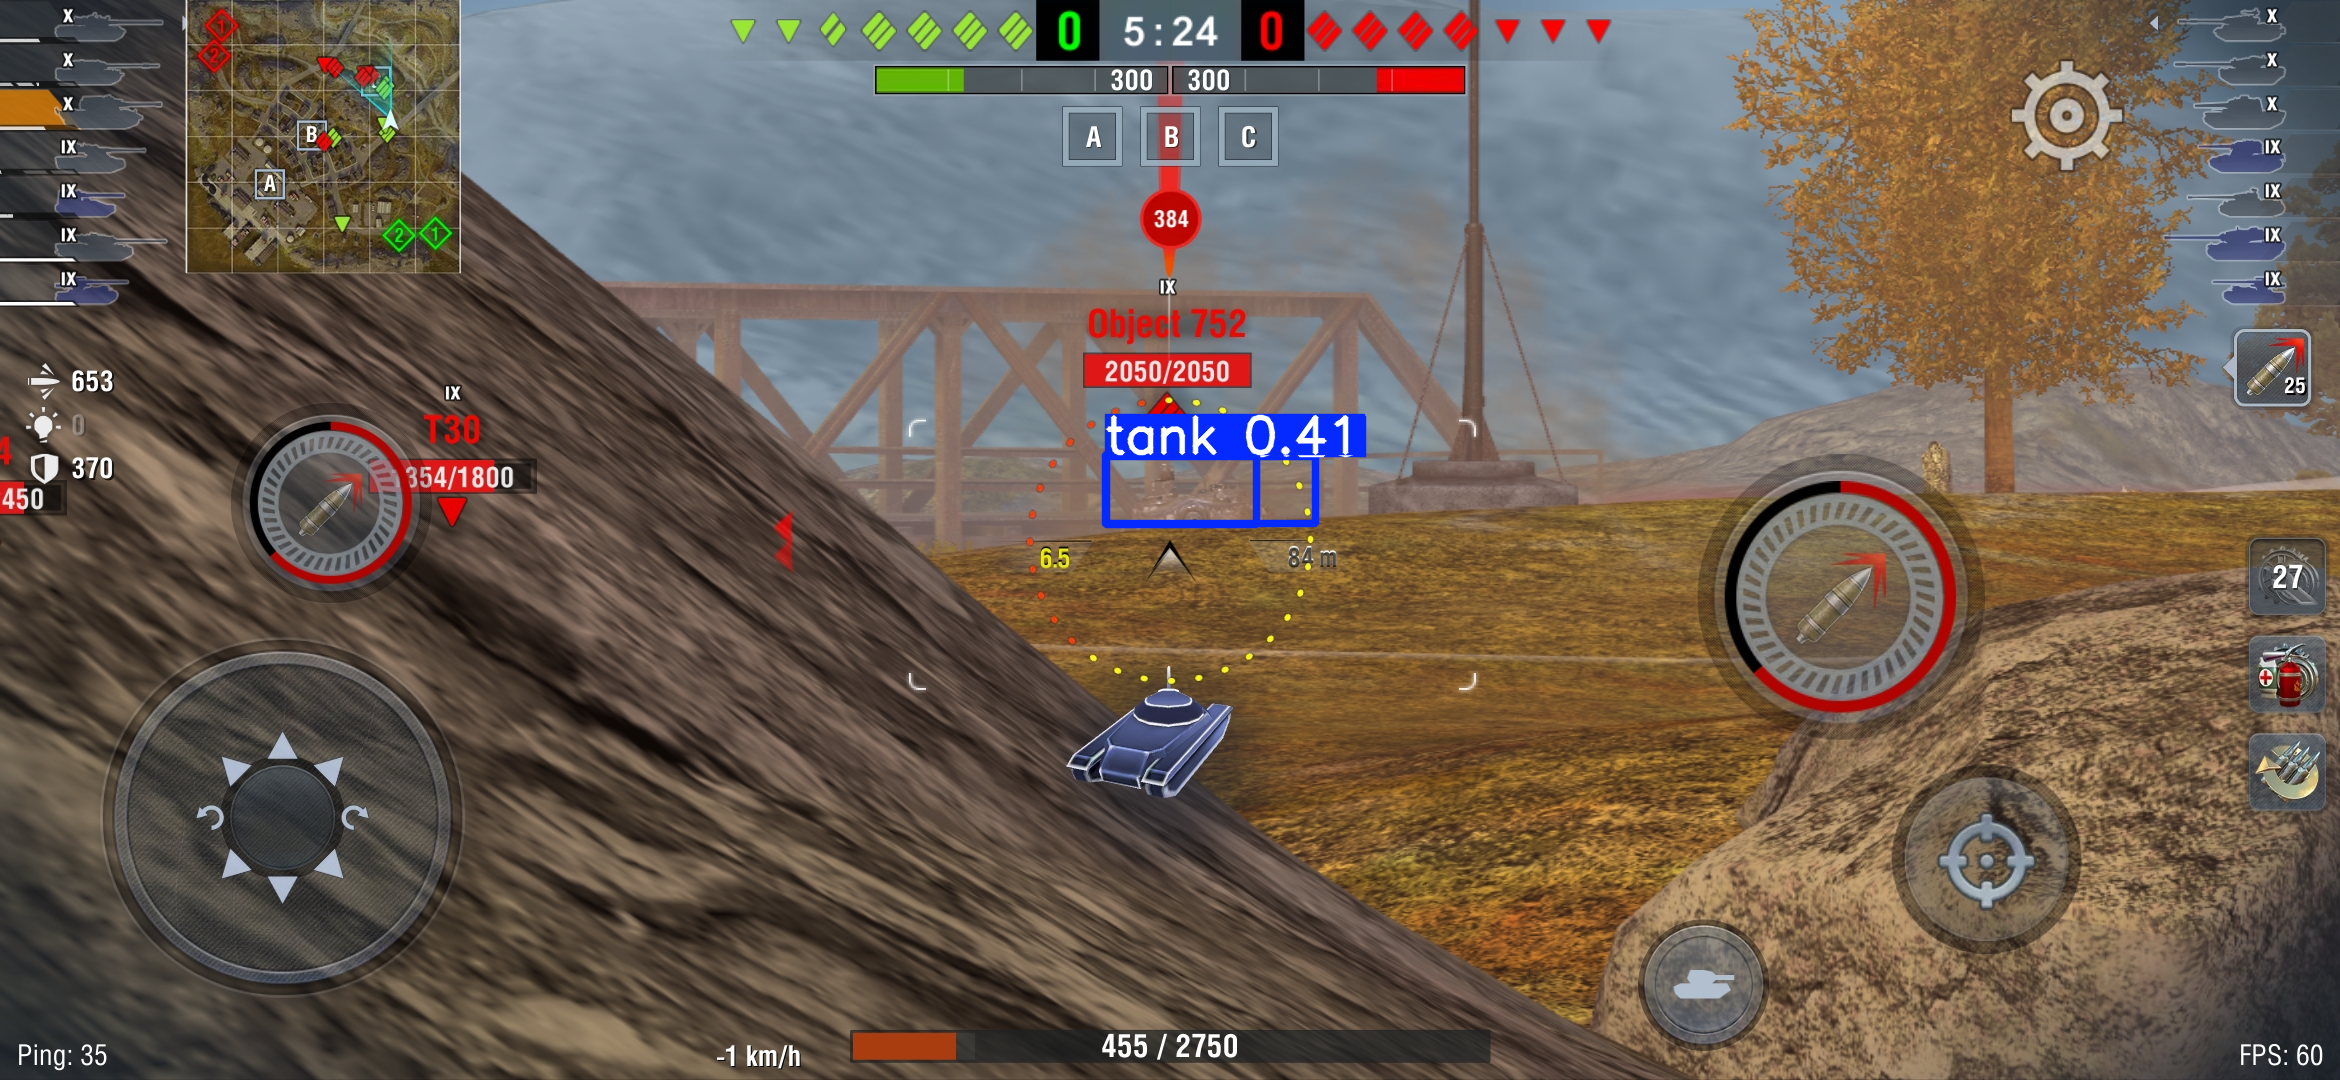

In [13]:
import random
from PIL import Image

# Get the list of test images
test_images_path = SCREENSHOTS_PATH+'/training_model/images/test'
test_images = glob.glob(os.path.join(test_images_path, '*.jpg'))

# Pick a random test image
random_image_path = random.choice(test_images)
print(f"Using random test image: {random_image_path}")

# Perform inference
results = best_model(random_image_path)

# Show the results
results[0].show()

## IOU on test dataset


In [14]:
import os
import xml.etree.ElementTree as ET
from ultralytics import YOLO
from PIL import Image


def bbox_iou(box1, box2):
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    inter = max(0, x2 - x1) * max(0, y2 - y1)
    area1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
    area2 = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union = area1 + area2 - inter

    return inter / union if union > 0 else 0.0


def parse_voc_xml(xml_path):
    tree = ET.parse(xml_path)
    root = tree.getroot()

    boxes = []
    labels = []

    for obj in root.findall("object"):
        name = obj.find("name").text

        bnd = obj.find("bndbox")
        x1 = float(bnd.find("xmin").text)
        y1 = float(bnd.find("ymin").text)
        x2 = float(bnd.find("xmax").text)
        y2 = float(bnd.find("ymax").text)

        boxes.append([x1, y1, x2, y2])
        labels.append(name)

    return boxes, labels


def compute_iou_voc(model_path, root_path, conf=0.25):
    """
    model_path: YOLO model .pt
    root_path: folder containing images/ and annotations/
    """

    images_dir = os.path.join(root_path, "images")
    ann_dir = os.path.join(root_path, "annotations")

    model = YOLO(model_path)
    ious = []

    for img_name in os.listdir(images_dir):
        if not img_name.lower().endswith((".jpg", ".jpeg", ".png")):
            continue

        img_path = os.path.join(images_dir, img_name)
        xml_path = os.path.join(ann_dir, img_name.rsplit(".", 1)[0] + ".xml")

        if not os.path.exists(xml_path):
            continue

        # Load GT
        gt_boxes, gt_labels = parse_voc_xml(xml_path)

        # Prediction
        res = model.predict(img_path, conf=conf, verbose=False)[0]
        pred_boxes = res.boxes.xyxy.cpu().numpy().tolist()

        # IoU calculations
        for pb in pred_boxes:
            best_iou = 0.0
            for gb in gt_boxes:
                best_iou = max(best_iou, bbox_iou(pb, gb))
            ious.append(best_iou)

    return sum(ious) / len(ious) if ious else 0.0

best_model(random_image_path)

In [15]:
iou_test = compute_iou_voc(best_model, SCREENSHOTS_PATH)

In [16]:
print(f"IOU on test dataset: {iou_test}")

IOU on test dataset: 0.8301250125488617


## Saving a model

In [17]:
model =YOLO(PROJECT_PATH+'/models_trained_on_screenshots/model_12.pt')
model.export(format='tflite', max_det=14)

Ultralytics 8.3.239 🚀 Python-3.12.12 torch-2.9.0+cu126 CPU (Intel Xeon CPU @ 2.00GHz)
💡 ProTip: Export to OpenVINO format for best performance on Intel hardware. Learn more at https://docs.ultralytics.com/integrations/openvino/
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs

PyTorch: starting from '/content/drive/My Drive/ML/source data/tanks/models_trained_on_screenshots/model_12.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 6, 8400) (5.9 MB)
requirements: Ultralytics requirements ['sng4onnx>=1.0.1', 'onnx_graphsurgeon>=0.3.26', 'ai-edge-litert>=1.2.0', 'onnx>=1.12.0,<2.0.0', 'onnx2tf>=1.26.3', 'onnxslim>=0.1.71', 'onnxruntime-gpu'] not found, attempting AutoUpdate...
Using Python 3.12.12 environment at: /usr
Resolved 20 packages in 7.07s
Prepared 11 packages in 5.15s
Installed 11 packages in 270ms
 + ai-edge-litert==2.0.3
 + backports-strenum==1.3.1
 + colorama==0.4.6
 + coloredlogs==15.0.1
 + humanfriendly==10.0
 + onnx==1.20.0
 

/usr/local/lib/python3.12/dist-packages/torch/onnx/_internal/torchscript_exporter/utils.py:1447: OnnxExporterWarning: Exporting to ONNX opset version 22 is not supported. by 'torch.onnx.export()'. The highest opset version supported is 20. To use a newer opset version, consider 'torch.onnx.export(..., dynamo=True)'. 
  warnings.warn(


ONNX: slimming with onnxslim 0.1.80...
ONNX: export success ✅ 3.8s, saved as '/content/drive/My Drive/ML/source data/tanks/models_trained_on_screenshots/model_12.onnx' (11.8 MB)
Unzipping calibration_image_sample_data_20x128x128x3_float32.npy.zip to /content/calibration_image_sample_data_20x128x128x3_float32.npy...: 100% ━━━━━━━━━━━━ 1/1 51.0files/s 0.0s
TensorFlow SavedModel: starting TFLite export with onnx2tf 1.28.6...
Saved artifact at '/content/drive/My Drive/ML/source data/tanks/models_trained_on_screenshots/model_12_saved_model'. The following endpoints are available:

* Endpoint 'serving_default'
  inputs_0 (POSITIONAL_ONLY): TensorSpec(shape=(1, 640, 640, 3), dtype=tf.float32, name='images')
Output Type:
  TensorSpec(shape=(1, 6, 8400), dtype=tf.float32, name=None)
Captures:
  133610977638544: TensorSpec(shape=(4, 2), dtype=tf.int32, name=None)
  133610977639120: TensorSpec(shape=(3, 3, 3, 16), dtype=tf.float32, name=None)
  133610977639312: TensorSpec(shape=(16,), dtype=tf.fl

'/content/drive/My Drive/ML/source data/tanks/models_trained_on_screenshots/model_12_saved_model/model_12_float32.tflite'

## Detecting objs on video:


In [19]:
p = best_model.predict(PROJECT_PATH+'/Screen_Recording_20251124_063804_WoT Blitz_1.mp4', save=True)

WARNING ⚠️ 
Inference results will accumulate in RAM unless `stream=True` is passed, which can cause out-of-memory errors for large
sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

Results saved to /content/runs/detect/predict


## Summary: YOLOv8 Tank Detection Model

This report summarizes the development and evaluation of a YOLOv8 object detection model for identifying tanks, with a specific focus on its application to World of Tanks (WoT) game screenshots.

### 1. Pre-training on Real Tank Photos

The initial step involved pre-training (or fine-tuning) a YOLOv8n model on a dataset of real-world tank photographs. This foundational training established a robust base for general tank recognition. The evaluation on this dataset yielded excellent results:

*   **mAP50**: 0.968
*   **mAP50-95**: 0.794
*   **Precision**: 0.992
*   **Recall**: 0.937

These metrics indicate a highly accurate and reliable model for detecting tanks in diverse photographic contexts.

### 2. Fine-tuning on World of Tanks Screenshots

To adapt the model to the distinct visual style of the WoT mobile game, the pre-trained model underwent a second phase of fine-tuning using a dataset of WoT screenshots. This process involved freezing a specific number of initial layers of the model's backbone to preserve learned features while allowing later layers to specialize in game-specific visual cues. Multiple configurations for frozen layers (10, 11, 12, 13, 15, 19, 22) were explored, though some models were restored from previous training runs.

The validation metrics for the fine-tuned models on the WoT screenshots were consistently strong:

*   **mAP50**: 0.927
*   **mAP50-95**: 0.743
*   **Precision**: 0.951
*   **Recall**: 0.864

These results demonstrate the model's effective adaptation to the game environment, maintaining high detection performance.

### 3. Test Dataset Evaluation

Further evaluation was conducted on a dedicated test dataset to assess the model's generalization capabilities. The Intersection Over Union (IOU) metric was used to quantify the overlap between predicted and ground truth bounding boxes.

*   **Average IOU on Test Dataset**: 0.830

An average IOU of 0.830 indicates a high degree of spatial accuracy in the model's predictions on unseen game screenshots, confirming its strong performance.

### 4. Tanks detection on a video

As a final test, a video of a game process was recorded and prediction boxes were allocated on the video to demonstrate how YOLO detects objects in real-life applications